## 1. Where are the old left-handed people?

<p>Throughout history, numerous notable individuals such as Barack Obama, Bill Gates, Oprah Winfrey, Babe Ruth, and Marie Curie have been left-handed. However, a thought-provoking <a href="https://www.nejm.org/doi/full/10.1056/NEJM199104043241418">study from 1991</a> claims that left-handed people tend to die, on average, nine years earlier than their right-handed counterparts. The validity of this claim raises questions that we aim to explore in this analysis.</p>
<p>Using age distribution data, this notebook endeavors to determine whether the observed difference in average age at death between left-handed and right-handed individuals can be solely attributed to the changing rates of left-handedness over time. We will leverage tools like <code>pandas</code> and Bayesian statistics to examine the probability of reaching certain ages at death based on reported hand preferences.</p>
<p>In 1986, researchers Avery Gilbert and Charles Wysocki conducted a National Geographic survey with over a million responses, capturing information on age, sex, and hand preference for throwing and writing. Upon analyzing the data, they discovered that the prevalence of left-handedness decreased with age - from around 13% for individuals younger than 40 to about 5% for those aged 80 and above. The researchers concluded that this age-dependence was primarily a result of the changing social acceptability of left-handedness, linking the rates not to <em>age</em> specifically but rather to the <em>birth year</em>. Consequently, if a similar study were conducted today, we would expect a shifted version of the same distribution as a function of age. Our primary objective is to assess how this changing rate impacts the apparent mean age of death for left-handed individuals. To begin, let's visualize the rates of left-handedness as a function of age.</p>
<p>This study relies on two datasets: <a href="https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf">death distribution data</a> for the United States from 1999 (source website <a href="https://www.cdc.gov/nchs/nvss/mortality_tables.htm">here</a>), and rates of left-handedness extracted from a figure presented in a <a href="https://www.ncbi.nlm.nih.gov/pubmed/1528408">1992 paper by Gilbert and Wysocki</a>.</p>

Text(0, 0.5, 'Gender')

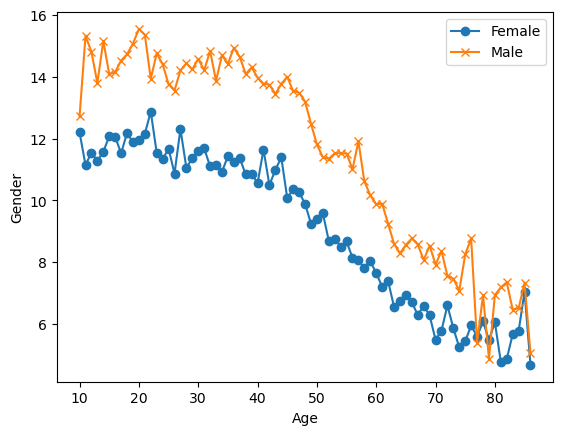

In [24]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

# load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot("Age","Female", data=lefthanded_data, marker = 'o') # plot "Female" vs. "Age"
ax.plot("Age", "Male", data=lefthanded_data, marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Gender")

## 2. Rates of left-handedness over time
<p>Let's convert this data into a plot of the rates of left-handedness as a function of the year of birth, and average over male and female to get a single rate for both sexes. </p>
<p>Since the study was done in 1986, the data after this conversion will be the percentage of people alive in 1986 who are left-handed as a function of the year they were born. </p>

Text(0, 0.5, 'lefthanded percentage')

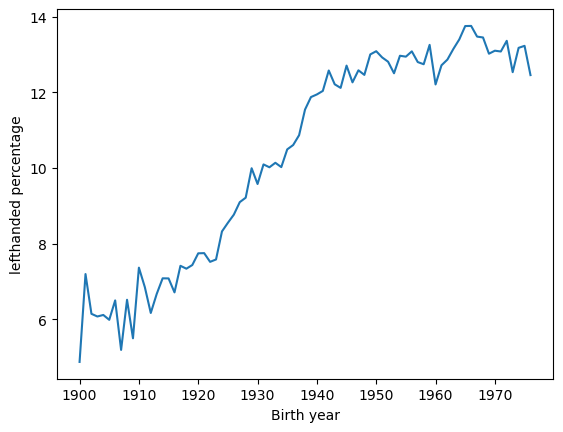

In [25]:
# create a new column for birth year of each age
# ... YOUR CODE FOR TASK 2 ...
lefthanded_data["Birth year"]=1986-lefthanded_data["Age"]
# create a new column for the average of male and female
# ... YOUR CODE FOR TASK 2 ...
lefthanded_data["Mean_lh"]=lefthanded_data[["Male", "Female"]].mean(axis=1)
# create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot("Birth year", "Mean_lh", data=lefthanded_data) # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel("Birth year") # set the x label for the plot
ax.set_ylabel("lefthanded percentage") # set the y label for the plot

## 3. Applying Bayes' rule
<p>The probability of dying at a certain age given that you're left-handed is <strong>not</strong> equal to the probability of being left-handed given that you died at a certain age. This inequality is why we need <strong>Bayes' theorem</strong>, a statement about conditional probability which allows us to update our beliefs after seeing evidence. </p>
<p>We want to calculate the probability of dying at age A given that you're left-handed. Let's write this in shorthand as P(A | LH). We also want the same quantity for right-handers: P(A | RH). </p>
<p>Here's Bayes' theorem for the two events we care about: left-handedness (LH) and dying at age A.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>P(LH | A) is the probability that you are left-handed <em>given that</em> you died at age A. P(A) is the overall probability of dying at age A, and P(LH) is the overall probability of being left-handed. We will now calculate each of these three quantities, beginning with P(LH | A).</p>
<p>To calculate P(LH | A) for ages that might fall outside the original data, we will need to extrapolate the data to earlier and later years. Since the rates flatten out in the early 1900s and late 1900s, we'll use a few points at each end and take the mean to extrapolate the rates on each end. The number of points used for this is arbitrary, but we'll pick 10 since the data looks flat-ish until about 1910. </p>

In [26]:
# import numpy library
import numpy as np

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate/100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
    
    return P_return

In [27]:
lefthanded_data.tail(10)

,Age,Male,Female,Birth year,Mean_lh
67,77,5.397068,5.593611,1909,5.495340
68,78,6.937204,6.091359,1908,6.514281
69,79,4.885999,5.490092,1907,5.188046
70,80,6.939382,6.056423,1906,6.497902
71,81,7.188198,4.779491,1905,5.983845
72,82,7.350204,4.874899,1904,6.112551
73,83,6.471204,5.672536,1903,6.071870
74,84,6.510858,5.774881,1902,6.142870
75,85,7.337968,7.051459,1901,7.194713
76,86,5.059387,4.680948,1900,4.870168


In [29]:
##load death_distribution_data
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
death_distribution_data= pd.read_csv(data_url_2,sep = '\t',skiprows=[1])
print(death_distribution_data.head())

   Age  Both Sexes     Male   Female
0    0     27937.0  15646.0  12291.0
1    1      1989.0   1103.0    886.0
2    2      1376.0    797.0    579.0
3    3      1046.0    601.0    445.0
4    4       838.0    474.0    364.0


## 4. When do people normally die?
<p>To estimate the probability of living to an age A, we can use data that gives the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution that gives the probability of dying at age A. The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. </p>
<p>In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age. </p>

Text(0, 0.5, 'Number of people who died')

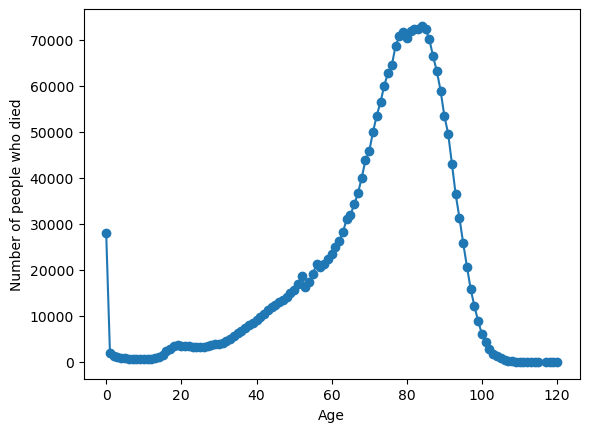

In [30]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data= pd.read_csv(data_url_2,sep = '\t',skiprows=[1])
# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset = ["Both Sexes"])
# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot("Age", "Both Sexes", data = death_distribution_data, marker='o') # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel("Age") 
ax.set_ylabel("Number of people who died")

In [31]:
death_distribution_data.head()


,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0


## 5. The overall probability of left-handedness
<p>In the previous code block we loaded data to give us P(A), and now we need P(LH). P(LH) is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where N(A) is the number of people who died at age A (given by the dataframe <code>death_distribution_data</code>):</p>
<p><img src="https://i.imgur.com/gBIWykY.png" alt="equation" width="220"></p>
<!--- $$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$ -->

In [32]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year) # multiply number of dead people by P_lh_given_A
    p = np.sum(p_list)# calculate the sum of p_list
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

print(P_lh(death_distribution_data))

0.07766387615350638


## 6. Putting it all together: dying while left-handed (i)
<p>Now we have the means of calculating all three quantities we need: P(A), P(LH), and P(LH | A). We can combine all three using Bayes' rule to get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to P(A | RH), the probability of being age A at death given that you're right-handed. </p>
<p>We're calculating the following quantity twice, once for left-handers and once for right-handers.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>First, for left-handers.</p>
<!--Notice that I was careful not to call these "probability of dying at age A", since that's not actually what we're calculating: we use the exact same death distribution data for each. -->

In [33]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

## 7. Putting it all together: dying while left-handed (ii)
<p>And now for right-handers.</p>

In [34]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1- P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # P_rh_A = 1 - P_lh_A 
    return P_rh_A*P_A/P_right

## 8. Plotting the distributions of conditional probabilities
<p>Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120. </p>
<p>Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger. </p>

Text(0, 0.5, 'Probability of being age A at death')

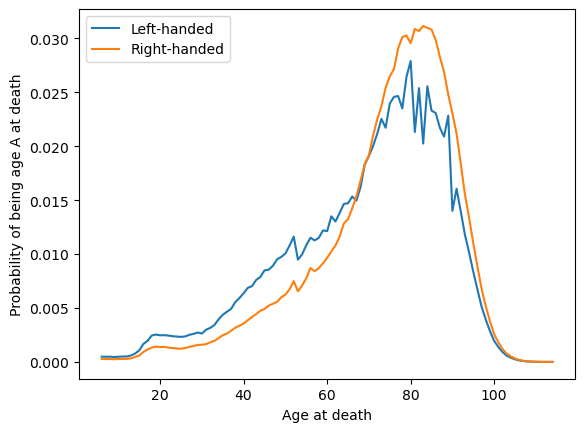

In [35]:
ages = np.arange(6, 115, 1) # make a list of ages of death to plot

# calculate the probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# create a plot of the two probabilities vs. age
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend() # add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

## 9. Moment of truth: age of left and right-handers at death
<p>Finally, let's compare our results with the original study that found that left-handed people were nine years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated P(LH) earlier, weighting the probability distribution by age and summing over the result.</p>
<p>$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$</p>
<p>$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$</p>

In [36]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =   np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.


## 10. Final comments
<p>The analysis focuses on the substantial age gap observed between left-handed and right-handed individuals, which can be attributed to the changing rates of left-handedness in the population. This observation carries positive implications for left-handers, indicating that their sinisterness is unlikely to be a factor in premature mortality. Over time, the reported prevalence of left-handedness has risen from a mere 3% in the early 1900s to approximately 11% in contemporary times.</p>
<p>However, when comparing our findings to a previous study, a notable difference in the magnitude of the age gap emerges. Several approximations were employed, possibly contributing to this disparity:</p>
<ol>
<li>The death distribution data used was nearly ten years later than that of the original study (1999 versus 1991), and the data encompassed the entire United States, not just California, which was the focus of the initial research.</li>
<li>Extrapolation of left-handedness survey results to different age groups could have led to deviations from the true rates for those particular age cohorts.</li>
</ol>
<p>As a future step, it would be prudent to explore the potential impact of variability resulting from random sampling on the age difference. Conducting a study with a smaller sample of recently deceased individuals, applying handedness probabilities from the survey, and analyzing the resulting distribution could shed light on the frequency of encountering a nine-year age gap using the same data and assumptions. However, this detailed analysis is beyond the scope of the present study, though it remains feasible with the available data and tools of random sampling.</p>
<!-- Additional tasks could be included with three more blocks if desired. -->
<p>Concluding the investigation, a calculation was performed to determine the age gap that would be expected if the study were conducted in 2018 instead of 1990. Notably, the gap is considerably smaller due to the fact that left-handedness rates have not significantly increased for individuals born after approximately 1960. Both the National Geographic study and the 1990 research were conducted during a unique period when the prevalence of left-handedness underwent notable changes across the lifetimes of most individuals, leading to a stark contrast in handedness between different age groups.</p>

In [37]:
# Calculate the probability of being left- or right-handed for all ages
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year = 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year = 2018)

# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 = np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
